# 03 - Stats Review: The Most Dangerous Equation

In his famous article of 2007, Howard Wainer writes about very dangerous equations:

"Some equations  are  dangerous  if you  know them, and others are dangerous if you do not. The first category may  pose  danger  because the secrets  within its bounds open  doors  behind which lies terrible peril. The obvious winner in this is Einstein’s iconic equation $E = MC^2$, for it  provides  a  measure of  the  enormous energy hidden  within  ordinary  matter. \[...\] Instead I am interested in equations that unleash their danger not when we know about them, but rather when we do not. Kept close at hand, these equations allow us to understand things clearly, but their absence leaves us dangerously ignorant."

The equation he talks about is Moivre’s equation:

$
SE = \dfrac{\sigma}{\sqrt{n}} 
$

where $SE$ is the standard error of the mean, $\sigma$ is the standard deviation and $n$ is the sample size. Sounds like a piece of math the brave and true should master, so let's get to it.

To see why not knowing this equation is very dangerous, let's take a look at some education data. I've compiled data on ENEM scores (Brazilian standardised high school scores, similar to SAT) from different schools for a period of 3 years. I also did some cleaning on the data to keep only the information relevant to us. The original data can be downloaded in the [Inep website](http://portal.inep.gov.br/web/guest/microdados#).

If we look at the top performing school, something catches the eye: those schools have a fairly small number of students. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Looking at it from another angle, we can separate only the 1% top schools and study them. What are they like? Perhaps we can learn something from the best and replicate it elsewhere. And sure enough, if we look at the top 1% schools, we figure out they have, on average, fewer students.

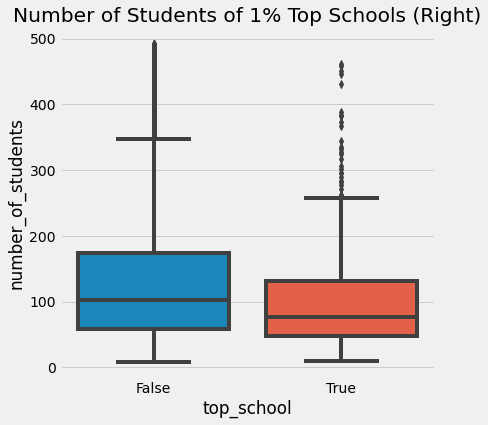

In [3]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

One natural conclusion that follows is that small schools lead to higher academic performance. This makes intuitive sense, since we believe that less students per teacher allows the teacher to give focused attention to each student. But what does this have to do with Moivre’s equation? And why is it dangerous? 

Well, it becomes dangerous once people start to make important and expensive decisions based on this information. In his article, Howard continues:

"In the 1990s, it became popular to champion reductions in the size of schools. Numerous philanthropic organisations and government agencies funded the division of larger schools based on the fact that students at small schools are over represented in groups with high test scores."

What people forgot to do was to look also at the bottom 1% of schools. If we do that, lo and behold! They also have very few students!

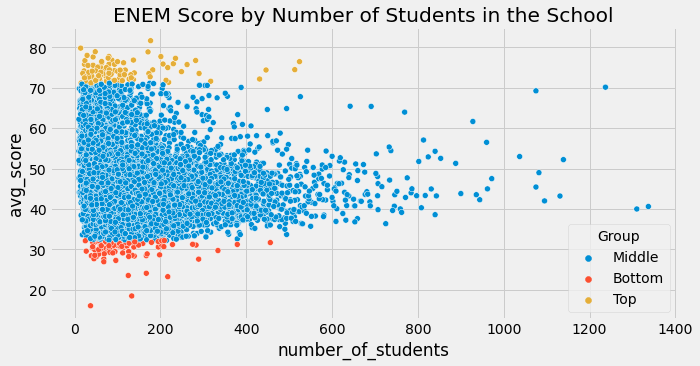

In [4]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

What we are seeing above is exactly what is expected according to the Moivre’s equation. As the number of students grows, the average score becomes more and more precise. Schools with very few samples can have very high and very low scores simply due to chance. This is less likely to occur with large schools. Moivre’s equation talks about a fundamental fact about the reality of information and records in the form of data: it is always imprecise. The question then becomes how imprecise.

Statistics is the science that deals with these imprecisions so they don't catch us off-guard. As Taleb puts it in his book, Fooled by Randomness:

> Probability is not a mere computation of odds on the dice or more complicated variants; it is the acceptance of the lack of certainty in our knowledge and the development of methods for dealing with our ignorance.

One way to quantify our uncertainty is the **variance of our estimates**. Variance tells us how much observation deviates from their central and most probably value. As indicated by Moivre’s equation, this uncertainty shrinks as the amount of data we observe increases. This makes sense, right? If we see lots and lots of students performing excellently at a school, we can be more confident that this is indeed a good school. However, if we see a school with only 10 students and 8 of them perform well, we need to be more suspicious. It could be that, by chance, that school got some above average students.

The beautiful triangular plot we see above tells exactly this story. It shows us how our estimates of the school performance has a huge variance when the sample sizes are small. It also shows that variance shrinks as the sample size increases. This is true for the average score in a school, but it is also true about any summary statistics that we have, including the ATE we so often want to estimate.

##  The Standard Error of Our Estimates

Since this is just a review on statistics, I'll take the liberty to go a bit faster now. If you are not familiar with distributions, variance and standard errors, please, do read on, but keep in mind that you might need some additional resources. I suggest you google any MIT course on introduction to statistics. They are usually quite good.

In the previous section, we estimated the average treatment effect $E[Y_1-Y_0]$ as the difference in the means between the treated and the untreated $E[Y|T=1]-E[Y|T=0]$. As our motivating example, we figured out the $ATE$ for online classes. We also saw that it was a negative impact, that is, online classes made students perform about 5 points worse than the students with face to face classes. Now, we get to see if this impact is statistically significant.

To do so, we need to estimate the $SE$. We already have $n$, our sample size. To get the estimate for the standard deviation we can do the following

$
\hat{\sigma}^2=\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2
$

where $\bar{x}$ is the mean of $x$. Fortunately for us, most programming software already implements this. In Pandas, we can use the method [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html).

In [5]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


## Confidence Intervals

The standard error of our estimate is a measure of confidence. To understand exactly what it means, we need to go into turbulent and polemic statistical waters. For one view of statistics, the frequentist view, we would say that the data we have is nothing more than a manifestation of a true data generating process. This process is abstract and ideal. It is governed by true parameters that are unchanging but also unknown to us. In the context of the students test, if we could run multiple experiments and collect multiple datasets, all would resemble the true underlying data generating process, but wouldn't be exactly like it. This is very much like Plato's writing on the Forms:

> Each [of the essential forms] manifests itself in a great variety of combinations, with actions, with material things, and with one another, and each seems to be many

To better grasp this, let's suppose we have a true abstract distribution of students' test score. This is a normal distribution with true mean of 74 and true standard deviation of 2. From this distribution, we can run 10000 experiments. On each one, we collect 500 samples. Some experiment data will have a mean lower than the true one, some will be higher. If we plot them in a histogram, we can see that means of the experiments are distributed around the true mean.

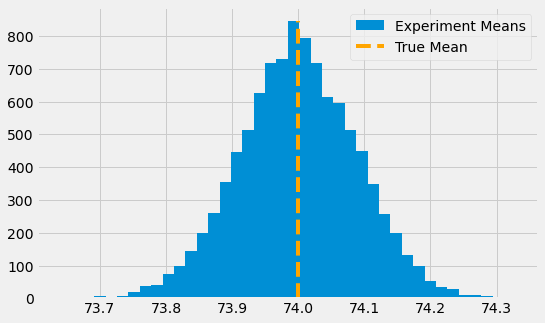

In [6]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();


Notice that we are talking about the mean of means here. So, by chance, we could have an experiment where the mean is somewhat below or above the true mean. This is to say that we can never be sure that the mean of our experiment matches the true platonic and ideal mean. However, **with the standard error, we can create an interval that will contain the true mean 95% of the time**.

In real life, we don't have the luxury of simulating the same experiment with multiple datasets. We often only have one. But we can draw on the intuition above to construct what we call **confidence intervals**. Confidence intervals come with a probability attached to them. The most common one is 95%. This probability tells us how many of the hypothetical confidence intervals we would build from different studies contain the true mean. For example, the 95% confidence intervals computed from many similar studies would contain the true mean 95% of the time. 

To calculate the confidence interval, we use what is called the **central limit theorem**. This theorem states that **means of experiments are normally distributed**. From statistical theory, we know that 95% of the mass of a normal distribution is between 2 standard deviations above and below the mean. Technically, 1.96, but 2 is close enough. 

![normal_density](./data/img/stats-review/normal_dist.jpeg)

The Standard Error of the mean serves as our estimate of the distribution of the experiment means. So, if we multiply it by 2 and add and subtract it from the mean of one of our experiments, we will construct a 95% confidence interval for the true mean.

In [7]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


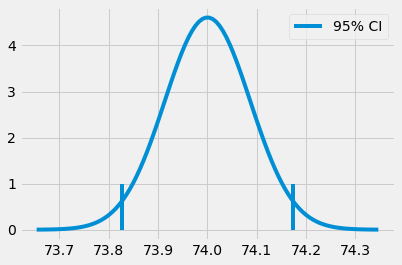

In [8]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

Of course, we don't need to restrict ourselves to the 95% confidence interval. We could generate the 99% interval by finding what we need to multiply the standard deviation by so the interval contains 99% of the mass of a normal distribution. 

The function `ppf` in python gives us the inverse of the CDF. So, `ppf(0.5)` will return 0.0, saying that 50% of the mass of the standard normal distribution is below 0.0. By the same token, if we plug 99.5%, we will have the value `z`, such that 99.5% of the distribution mass falls below this value. In other words, 0.05% of the mass falls above this value. Instead of multiplying the standard error by 2 like we did to find the 95% CI, we will multiply it by `z`, which will result in the 99% CI.

In [9]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

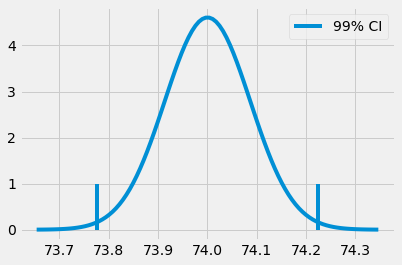

In [10]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

Back to our classroom experiment, we can construct the confidence interval for the mean exam score for both the online and face to face students' group

In [11]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


What we can see is that the 95% CI of the groups don't overlap. The lower end of the CI for Face to Face class is above the upper end of the CI for online classes. This is evidence that our result is not by chance, and that the true mean for students in face to face clases is higher than the true mean for students in online classes. In other words, there is a significant causal decrease in academic performance when switching from face to face to online classes.

As a recap, confidence intervals are a way to place uncertainty around our estimates. The smaller the sample size, the larger the standard error and the wider the confidence interval. Finally, you should always be suspicious of measurements without any uncertainty metric attached to it. Since they are super easy to compute, lack of confidence intervals signals either some bad intentions or simply lack of knowledge, which is equally concerning. 

![img](data/img/stats-review/ci_xkcd.png)

One final word of caution here. Confidence intervals are trickier to interpret than at first glance. For instance, I **shouldn't** say that this particular 95% confidence interval contains the true population mean with 95% chance. That's because in frequentist statistics, the one that uses confidence intervals, the population mean is regarded as a true population constant. So it either is or isn't in our particular confidence interval. In other words, our particular confidence interval either contains or doesn't contain the true mean. If it does, the chance of containing it would be 100%, not 95%. If it doesn't, the chance would be 0%. Rather, in confidence intervals, the 95% refers to the frequency that such confidence intervals, computed in many many studies, contain the true mean. 95% is our confidence in the algorithm used to compute the 95% CI, not on the particular interval itself.

Now, having said that, as an Economist (statisticians, please look away now), I think this purism is not very useful. In practice, you will see people saying that the particular confidence interval contains the true mean 95% of the time. Although wrong, this is not very harmful, as it still places a precise degree of uncertainty in our estimates. Moreover, if we switch to Bayesian statistics and use probable intervals instead of confidence intervals, we would be able to say that the interval contains the distribution mean 95% of the time. Also, from what I've seen in practice, with decent sample sizes, bayesian probability intervals are more similar to confidence intervals than both bayesian and frequentists would like to admit. So, if my word counts for anything, feel free to say whatever you want about your confidence interval. I don't care if you say they contain the true mean 95% of the time. Just, please, never forget to place them around your estimates, otherwise you will look silly. 


## Hypothesis Testing

Another way to incorporate uncertainty is to state a hypothesis test: is the difference in means statistically different from zero (or any other value)? To do so, we will recall that the sum or difference of 2 independent normal distributions is also a normal distribution. The resulting mean will be the sum or difference between the two distributions, while the variance will always be the sum of the variance:

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

If you don't recall, its OK. We can always use code and simulated data to check:

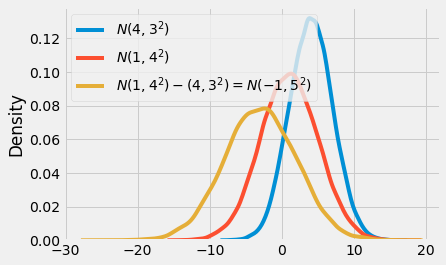

In [12]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-1, 5^2)$")
plt.legend()
plt.show()

If we take the distribution of the means of our 2 groups and subtract one from the other, we will have a third distribution. The mean of this final distribution will be the difference in the means and the standard deviation of this distribution will be the square root of the sum of the standard deviations.

$
\mu_{diff} = \mu_1 - \mu_2
$

$
SE_{diff} = \sqrt{SE_1 + SE_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

Let's return to our classroom example. We will construct this distribution of the difference. Of course, once we have it, building the 95% CI is very easy.

In [13]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


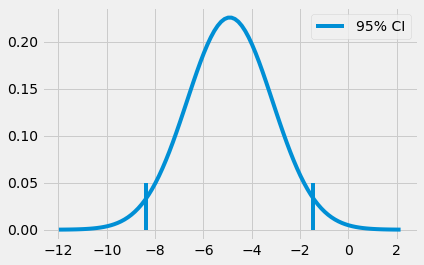

In [14]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

With this at hand, we can say that we are 95% confident that the true difference between the online and face to face group falls between -8.37 and -1.44. We can also construct a **z statistic** by dividing the difference in mean by the \$SE\\$ of the differences.

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

Where $H_0$ is the value which we want to test our difference against.

The z statistic is a measure of how extreme the observed difference is. To test our hypothesis that the difference in the means is statistically different from zero, we will use contradiction. We will assume that the opposite is true, that is, we will assume that the difference is zero. This is called a null hypothesis, or $H_0$. Then, we will ask ourselves "is it likely that we would observe such a difference if the true difference were indeed zero?" In statistical math terms, we can translate this question to checking how far from zero is our z statistic. 

Under $H_0$, the z statistic follows a standard normal distribution. So, if the difference is indeed zero, we would see the z statistic within 2 standard deviations of the mean 95% of the time. The direct consequence of this is that if z falls above or below 2 standard deviations, we can reject the null hypothesis with 95% confidence.

Let's see how this looks like in our classroom example.

In [15]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


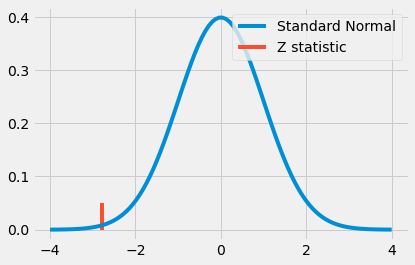

In [16]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

This looks like a pretty extreme value. Indeed, it is above 2, which means there is less than a 5% chance that we would see such an extreme value if there were no difference in the groups. This again leads us to conclude that switching from face to face to online classes causes a statistically significant drop in academic performance.

One final interesting thing about hypothesis tests is that it is less conservative than checking if the 95% CI from the treated and untreated group overlaps. In other words, if the confidence intervals in the two groups overlap, it can still be the case that the result is statistically significant. For example, let's pretend that the face-to-face group has an average score of 80 and standard error of 4 and the online group has an average score of 71 with a standard error of 2. 

In [17]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


If we construct the confidence intervals for these groups, they overlap. The upper bound for the 95% CI of the online group is 74.92 and the lower bound for the face-to-face group is 72.16. However, once we compute the 95% confidence interval for the difference between the groups, we can see that it does not contain zero. In summary, even though the individual confidence intervals overlap, the difference can still be statistically different from zero.

## P-values

I've said previously that there is less than 5% chance that we would observe such an extreme value if the difference between online and face to face groups were actually zero. But can we estimate exactly what is that chance? How likely are we to observe such an extreme value? Enters p-values!

Just like with confidence intervals (and most frequentist statistics, as a matter of fact) the true definition of p-values can be very confusing. So, to not take any risks, I'll copy the definition from Wikipedia: "the p-value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct". 

To put it more succinctly, the p-value is the probability of seeing such data, given that the null-hypothesis is true. It measures how unlikely it is that you are seeing a measurement if the null-hypothesis is true. Naturally, this often gets confused with the probability of the null-hypothesis being true. Note the difference here. The p-value is NOT $P(H_0|data)$, but rather $P(data|H_0)$.

But don't let this complexity fool you. In practical terms, they are pretty straightforward to use.

![p_value](./data/img/stats-review/p_value.png)

To get the p-value, we need to compute the area under the standard normal distribution before or after the z statistic. Fortunately, we have a computer to do this calculation for us. We can simply plug the z statistic in the CDF of the standard normal distribution.

In [18]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835563383


This means that there is only a 0.2% chance of observing this extreme z statistic if the difference was zero. Notice how the p-value is interesting because it avoids us having to specify a confidence level, like 95% or 99%. But, if we wish to report one, from the p-value, we know exactly at which confidence our test will pass or fail. For instance, with a p-value of 0.0027, we know that we have significance up to the 0.2% level. So, while the 95% CI and the 99% CI for the difference will neither contain zero, the 99.9% CI will.

In [19]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916459)


## Key Ideas

We've seen how important it is to know Moivre’s equation and we used it to place a degree of certainty around our estimates. Namely, we figured out that the online classes cause a decrease in academic performance compared to face to face classes. We also saw that this was a statistically significant result. We did it by comparing the Confidence Intervals of the means for the 2 groups, by looking at the confidence interval for the difference, by doing a hypothesis test and by looking at the p-value. Let's wrap everything up in a single function that does A/B testing comparison like the one we did above

In [20]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


Since our function is generic enough, we can test other null hypotheses. For instance, can we try to reject that the difference between online and face to face class performance is -1. With the results we get, we can say with 95% confidence that the difference is greater than -1. But we can't say it with 99% confidence:

In [21]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630114


## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

In this particular section, I've also referenced The [Most Dangerous Equation](https://www.researchgate.net/publication/255612702_The_Most_Dangerous_Equation), by Howard Wainer.

Finally, if you are curious about the correct interpretation of the statistical concepts we've discussed here, I recommend reading the paper by Greenland et al, 2016: [Statistical tests, P values, confidence intervals, and power: a guide to misinterpretations](https://link.springer.com/content/pdf/10.1007/s10654-016-0149-3.pdf).

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).